# Rule-based Classifier

In [5]:
import pandas as pd
import numpy as np

We import the dataset already splitted.

In [24]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [26]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [27]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [28]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

Given that this model supports both categorical and numerical features, in the various attempts to find the best model, combinations of both were tried out. This is why the pipeline also supports categorical features.

In [29]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', 'passthrough', cat_features)
    ]
)

## RIPPER Model

In [30]:
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline


We user RIPPER rule based classifier combined with a random search of the hyperparameters due to the large number of possible combinations and the slow training time of the model.

In [31]:

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                       ('classifier', lw.RIPPER())])
param_grid = {
    'classifier__prune_size': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__dl_allowance': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__k': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

#random grid
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=5, verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1,
                                   scoring=scoring, 
                                   refit='f1',
                                   return_train_score=True)
random_search.fit(train_data, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__dl_allowance=0.3, classifier__k=8, classifier__prune_size=0.1; total time=  41.6s
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 1.4min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 2.3min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 2.5min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 2.7min
[CV] END classifier__dl_allowance=0.3, classifier__k=8, classifier__prune_size=0.1; total time= 2.1min
[CV] END classifier__dl_allowance=0.3, classifier__k=8, classifier__prune_size=0.1; total time=  43.9s
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 3.2min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 3.6min
[CV] END cl

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('sampler',
                                              RandomUnderSampler(random_state=42,
                                                                 sampling_strategy=0.5)),
                                             ('...
                                              <RIPPER(max_total_conds=None, max_rules=None, verbosity=0, prune_size=0.33, n_discretize_bins=10, max_rule_conds=None, random_state=None, alpha=1.0, dl_allowance=64, k=2)>)]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__dl_allowance': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'classifier__k': [2, 3, 4, 5, 6, 7, 8,
                                                          9, 10],
                                        'classifier__prune_size': [0.1, 0.2,
                                                                   0.3, 0.4,
                                                                   0.5]},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                   verbose=2)

## Model Assessment

### Training scores:

In [ ]:
# extract the results of the randomized search and best model idx
cv_results = random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_train_scores = {metric: cv_results[f'mean_train_{metric}'][best_index] for metric in scoring.keys()}
std_train_scores = {metric: cv_results[f'std_train_{metric}'][best_index] for metric in scoring.keys()}

print("Training results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_train_scores[metric]:.4f}, Std: {std_train_scores[metric]:.4f}")


Training results of the best model:
Sensitivity - Mean: 0.4509, Std: 0.0114
Specificity - Mean: 0.8520, Std: 0.0059
Accuracy - Mean: 0.7988, Std: 0.0036
Precision - Mean: 0.3184, Std: 0.0033
Recall - Mean: 0.4509, Std: 0.0114
Roc_auc - Mean: 0.7458, Std: 0.0001
F1 - Mean: 0.3731, Std: 0.0018


### Validation scores

In [32]:
# extract the results of the randomized search and best model idx
cv_results = random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring}

print("Validation results of the best model:")
for metric in scoring:
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Accuracy - Mean: 0.7698, Std: 0.0208
Precision - Mean: 0.2965, Std: 0.0232
Recall - Mean: 0.5254, Std: 0.0342
F1 - Mean: 0.3781, Std: 0.0204


### Test scores

Accuracy: 0.723
Recall: 0.588
Precision: 0.285
Sensitivity: 0.588
Specificity: 0.747
F1 Score: 0.384
ROC AUC Score: 0.667


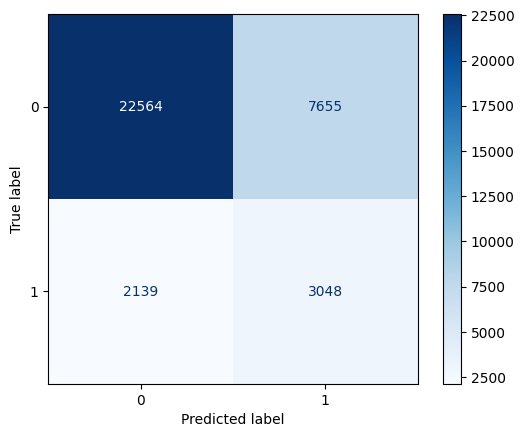

In [33]:
# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [34]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82     30219
           1       0.28      0.59      0.38      5187

    accuracy                           0.72     35406
   macro avg       0.60      0.67      0.60     35406
weighted avg       0.82      0.72      0.76     35406



## Save Results

In [ ]:
import sys
sys.path.append('..')
from utils import save_results

resampling = "no"   # "no", "under", "over", "smotetomek"
save_results('rule_based', resampling, mean_train_scores, std_train_scores, mean_test_scores, std_test_scores, accuracy, recall, precision, sensitivity_score, specificity_score, f1, roc_auc, report)

## Model Save

In [35]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/rule_based.pkl')

['best_models/nb.pkl']

### Rule Extraction

In [30]:
import joblib
import wittgenstein
# load the best RIPPER model
best_model = joblib.load('best_models/rule_based.pkl')

#extract the rules
rules = best_model.named_steps['classifier'].ruleset_.rules

# Print the rules
for i, rule in enumerate(rules):
    print(f"Rule {i + 1}:")
    print(rule)
    print(rule)
    print()



Rule 1:
[6=>1.53]

Rule 2:
[6=1.25-1.53]

Rule 3:
[6=0.89-1.25^1=-0.43--0.17^4=-1.42--1.03]

Rule 4:
[6=0.89-1.25]



Now we make the rules more interpretable.

In [56]:
import re

# fit the scaler to the training data
num_transformer.fit(train_data[numeric_features])

# extract mean and variance from the scaler
mean = num_transformer.mean_
std = np.sqrt(num_transformer.var_)

# function to easily denormalize a value
def denormalize(normalized_value, feature_index):
    return round((normalized_value * std[feature_index]) + mean[feature_index], 2)

# create a dict of feature names
feature_names = list(test_data.columns)
feat_names = {
    6 : feature_names[6],
    1 : feature_names[1],
    4 : feature_names[4]
}

# create a key-value pair of values to replace with its denormalized value (since it is a bit tricky to deal with the strings)
feat_values = {
    1.53: denormalize(1.53, 6),
    1.25: denormalize(1.25, 6),
    0.89: denormalize(0.89, 6),
    -0.43: denormalize(-0.43, 1),
    -0.17: denormalize(-0.17, 1),
    -1.42: denormalize(-1.42, 4),
    -1.03: denormalize(-1.03, 4)
}


# for each rule, substitute the feature index with the feature name
for i, rule in enumerate(rules):
    rule_str = str(rule)
    for key, value in feat_names.items():
        rule_str = rule_str.replace(f"[{key}=", f"[{value}=")
        rule_str = rule_str.replace(f"^{key}=", f"^{value}=")

    # replace the feature values with the denormalized values
    for k, v in feat_values.items():
        rule_str = rule_str.replace(str(k), str(v))
    
    # replace ^ with AND and put a space before and after
    rule_str = re.sub(r'\^', ' AND ', rule_str)
        
    print(f"Rule {i + 1}:")
    print(rule_str)
    print()

Rule 1:
[top_20_entropy=>0.94]

Rule 2:
[top_20_entropy=0.85-0.94]

Rule 3:
[top_20_entropy=0.74-0.85 AND cyclist_age=27.01-28.02 AND avg_relative_position=0.28-0.34]

Rule 4:
[top_20_entropy=0.74-0.85]



**Interpretation**

The model has extracted 4 rules to classify the top 20 cyclists, using 3 features: ```top_20_entropy```, ```cyclist_age``` and ```avg_relative_position```.

- **Rule 1**: when the entropy of top 20 cyclists is greater or equal than 0.94, the model captures instances where variability among the top 20 cyclists is high.
- **Rule 2**: same reasoning but this time the entropy value is bounded by 0.85 and 0.94
- **Rule 3**: there are thre AND conditions to be met: lower range of the entropy, narrower age interval and relatively (averaged) front positioned cyclists.
- **Rule 4**: captures a moderated entropy value, between 0.74 and 0.85, without extra conditions.

The model seems to focus a lot on the entropy of the top 20 cyclists for the prediction but it is not used in a correct way: the Rule 1 classifies in the top 20 cyclists those with higher entropy! As we highlited in the extra analysis, the mutual information we printed between the feature and the labels is higher for ```top_20_entropy``` so we suppose this is the reason why the model tends to use more this feature. Moreover, the Rule 3 and 4 are in some way overlapped since if the 3 is true the 4 is true as well.

## Results

We tried several combinations of features and hyperparameters, but the models doesn't seem to improve much, probably due to the nature of the data. Ovesampling seems time consuming and not very effective so we decided to focus more on the undersampling which seemed to give better results also with other models. Despite a lower accuracy without undersampling, the model has a better F1 score which we used as the main metric to evaluate the model.

NORMAL
Validation results of the best model:
Accuracy - Mean: 0.8680, Std: 0.0016
Precision - Mean: 0.5197, Std: 0.0435
Recall - Mean: 0.0679, Std: 0.0205
F1 - Mean: 0.1193, Std: 0.0331

UNDERSAMPLING
Validation results of the best model:
Accuracy - Mean: 0.7698, Std: 0.0208
Precision - Mean: 0.2965, Std: 0.0232
Recall - Mean: 0.5254, Std: 0.0342
F1 - Mean: 0.3781, Std: 0.0204